In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data import sampler, Subset
from torch.optim import lr_scheduler

import torchvision.datasets as dset
import torchvision.transforms as T

from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import LinearSVC
# from sklearn.linear_model import LogisticRegression

from PIL import Image

# constants
repo_path = Path('/Users/etriesch/dev/tree-finder/')
model_path = repo_path / 'models'

# disable warnings
Image.MAX_IMAGE_PIXELS = None # image processing 

In [2]:
# setup computing
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [3]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# define paths
repo_path = Path('git/tree-finder/')
full_repo_path = Path('/content/drive/My Drive ') / repo_path
model_path = full_repo_path / 'models'

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(repo_path))

Mounted at /content/drive


In [64]:
# setup cell
from notebooks.plot_fns import show_image_batch, set_plt_settings, plot_accs
from notebooks.train_fns import flatten, Flatten, train_model
from notebooks.data_processing import define_transforms, make_dataloaders, IMAGE_DIM, MEAN, STD
from notebooks.models import ResnetBinClassifier
from notebooks.scrape_fns import get_filelist

# And change jupyter settings to auto-reload these functions before each instance running them
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
set_plt_settings()

# Make dataset and loaders
This includes augmenting my dataset

In [6]:
# define transformations
transforms = define_transforms(scale_up=1024, crop=1024, scale_out=IMAGE_DIM, mean=MEAN, std=STD)
# create dataset by concatenating all transformations
treeds = []
for t in transforms:
    df = dset.ImageFolder(root=full_repo_path / 'data/images_spec', transform=transforms[t])
    treeds.append(df)

treeds = ConcatDataset(treeds)
class_names = treeds.datasets[0].classes

In [7]:
# make dataloaders
N = len(treeds)

# make whole-dataset loader and subset loader
loader_all = DataLoader(dataset=treeds, batch_size=N, shuffle=False)
loader_small = DataLoader(dataset=treeds, batch_size=25, 
                          sampler=sampler.SubsetRandomSampler(range(0, 500)))
loader_samp = DataLoader(dataset=treeds, batch_size=4, shuffle=True)

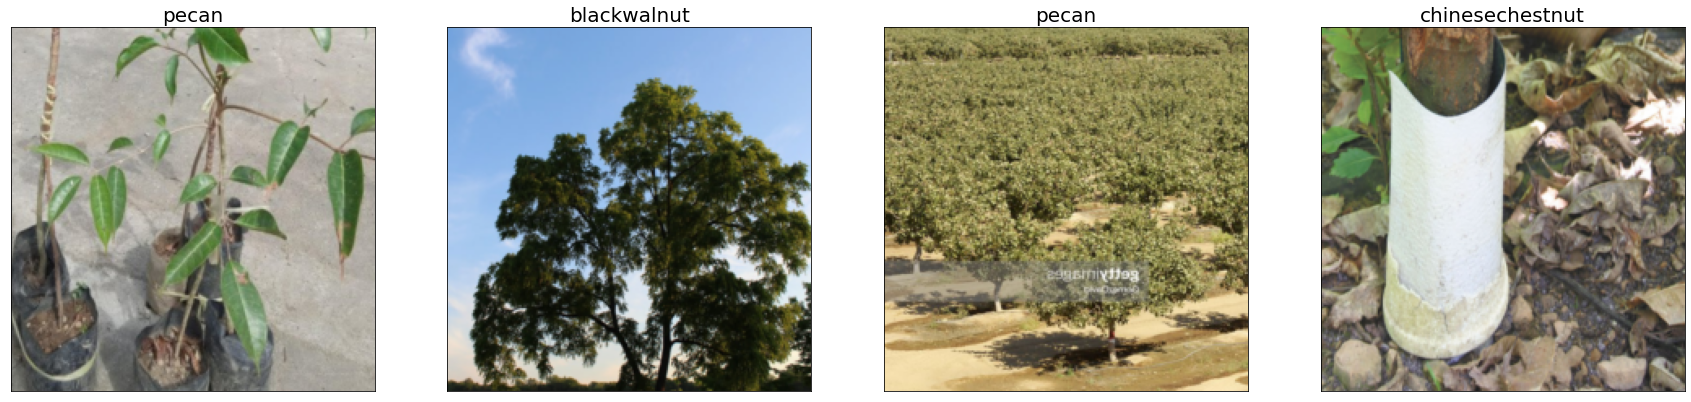

In [8]:
# visualize images
samp_imgs, samp_classes = next(iter(loader_samp))

# print(type(imgs), type(labels))
show_image_batch(samp_imgs, mean, std, title=[class_names[x] for x in samp_classes])

# Subset dataset to images that a binary classifier classifies as trees

In [ ]:
# load binary classifier
model = ResnetBinClassifier(resnet50=True)
model.load_state_dict(torch.load(model_path / 'ResnetBinClassifier.pt', map_location=torch.device('cpu')))
model.to(device)
model.eval()

In [19]:
# load all images
loader = loader_small
batch = loader.batch_size
N = batch * len(loader)
X_in, __ = next(iter(loader))
# mount to right processor
X_in = X_in.to(device=device, dtype=dtype)  # move to device, e.g. GPU

In [20]:
# get scores for all images
scores = model(X_in)
percentage = F.softmax(scores, dim=1) * 100

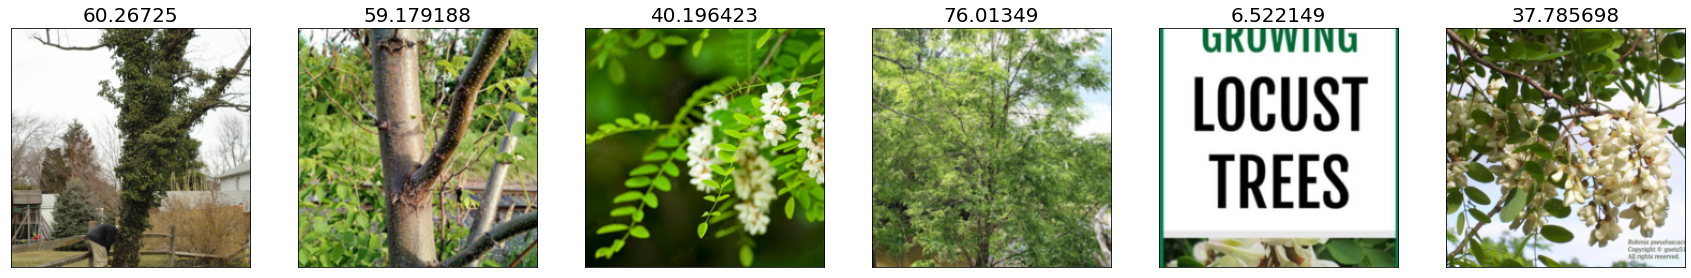

In [26]:
# print trees and score for detecting tree for a random sample of images
display_idxs = np.random.choice(range(batch), 6, replace=False)
tree_likelihood = percentage[:,1].detach().cpu().numpy()
show_image_batch(X_in[display_idxs].cpu(), mean, std, title=tree_likelihood[display_idxs])

In [27]:
# subset to images that pass tree threshold
tree_class_threshold = 0.55
tree_idxs = np.arange(0, batch)[tree_likelihood >= tree_class_threshold].tolist()

# subset the dataset
treeds_sub = torch.utils.data.Subset(treeds, tree_idxs)

In [28]:
# make dataloaders with the subset data
dataloaders, ds_sizes = make_dataloaders(dataset=treeds, pct_train=0.75, pct_val=0.15, sampleN=4)
# dataloaders, ds_sizes = make_dataloaders(dataset=treeds_sub, pct_train=0.75, pct_val=0.15, sampleN=4)

dataloader sizes: {'all': 32832, 'train': 24624, 'validate': 4924, 'test': 3284, 'sample': 4}


# Summarize original, augmented, and subset datasets

In [29]:
tree_filelist = get_filelist(full_repo_path / 'data/images_spec')

In [30]:
tree_summary = dict.fromkeys(tree_filelist.keys(), [0,0,0,0])
for k, i in tree_filelist.items():
  a = np.array(i)
  count_all = len(a)
  count_bing = len(a[np.char.startswith(a, 'bing-')])
  count_arbor = len(a[np.char.startswith(a, 'arborday-')])
  count_harvard = len(a[np.char.startswith(a, 'harvard-')])
  tree_summary[k] = [count_all, count_bing, count_arbor, count_harvard]

In [31]:
print('original dataset (all, bing, arborday, harvard):')
print(tree_summary)
print('augmented dataset:')
tree_summary_aug = tree_summary
for k in tree_summary.keys():
  tree_summary_aug[k] = [d*8 for d in tree_summary[k]]
print(tree_summary_aug)
print('filtered dataset: TBD')


original dataset (all, bing, arborday, harvard):
{'blacklocust': [605, 562, 0, 43], 'blackwalnut': [651, 563, 4, 84], 'northernredoak': [579, 531, 7, 41], 'loblollypine': [495, 488, 7, 0], 'chinesechestnut': [662, 467, 3, 192], 'honeylocust': [501, 501, 0, 0], 'pecan': [611, 591, 6, 14]}
augmented dataset:
{'blacklocust': [4840, 4496, 0, 344], 'blackwalnut': [5208, 4504, 32, 672], 'northernredoak': [4632, 4248, 56, 328], 'loblollypine': [3960, 3904, 56, 0], 'chinesechestnut': [5296, 3736, 24, 1536], 'honeylocust': [4008, 4008, 0, 0], 'pecan': [4888, 4728, 48, 112]}
filtered dataset: TBD


# Move to new notebook after I can figure out how to save filtered data

In [61]:
# define small loader for testing
small_data_train_size = 200
small_data_validate_size = 50
small_batch_size = 20
small_loaders = {}
small_loaders['train'] = DataLoader(treeds, batch_size=small_batch_size,
                           sampler=sampler.SubsetRandomSampler(np.random.randint(0, len(treeds), small_data_train_size)))
small_loaders['validate'] = DataLoader(treeds, batch_size=small_batch_size,
                           sampler=sampler.SubsetRandomSampler(np.random.randint(0, len(treeds), small_data_validate_size)))
small_ds_sizes = {'train':small_data_train_size, 'validate':small_data_validate_size}

# define loader to be used below
loaders = small_loaders
sizes = small_ds_sizes
# loaders = dataloaders
# sizes = ds_sizes

### Random guessing

In [62]:
mr_random = 1 / len(class_names)
print(mr_random)

0.14285714285714285


## Softmax

In [65]:
# define the model, optimizer, and scheduler (for lr decay)
model_sm = nn.Sequential(
    Flatten(),
    nn.Linear(IMAGE_DIM*IMAGE_DIM*3, len(class_names)),
    nn.Softmax(dim=1)
    ).to(device)
optimizer_sm = optim.Adam(model_sm.parameters(), lr=0.001, betas=(0.9, 0.99))
schedlr_sm = lr_scheduler.StepLR(optimizer_sm, step_size=2, gamma=0.1) # lr decay
criterion_sm = nn.NLLLoss()

train epoch: [1/3] Loss: -0.1784 ACC@1: 17.50%: 100%|██████████| 10/10 [01:48<00:00, 10.80s/it]
validate epoch: [1/3] Loss: -0.2607 ACC@1: 26.00%: 100%|██████████| 3/3 [00:18<00:00,  6.28s/it]
train epoch: [2/3] Loss: -0.1955 ACC@1: 19.50%: 100%|██████████| 10/10 [01:47<00:00, 10.71s/it]
validate epoch: [2/3] Loss: -0.1985 ACC@1: 20.00%: 100%|██████████| 3/3 [00:19<00:00,  6.38s/it]
train epoch: [3/3] Loss: -0.1798 ACC@1: 18.00%: 100%|██████████| 10/10 [01:47<00:00, 10.79s/it]
validate epoch: [3/3] Loss: -0.2097 ACC@1: 20.00%: 100%|██████████| 3/3 [00:19<00:00,  6.44s/it]


Returning best model, with validation accuracy 0.26


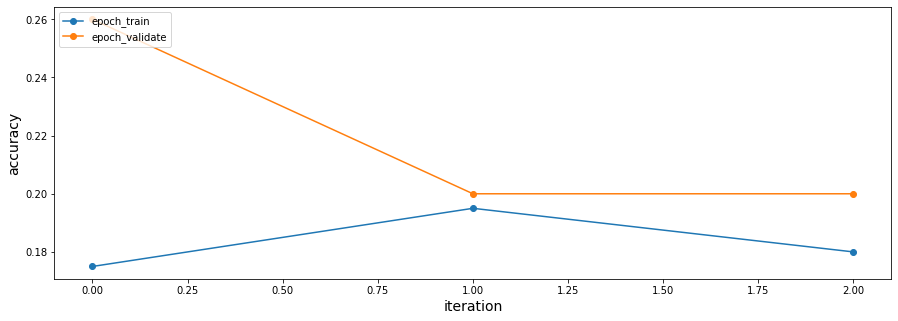

In [68]:
acc_history_sm = train_model(model_sm, criterion_sm, optimizer_sm, schedlr_sm,
                             loaders, sizes, device, 3)
plot_accs({key: acc_history_sm[key] for key in ['epoch_train', 'epoch_validate']})

## Hinge loss (SVM)

In [69]:
model_mh = nn.Sequential(
    Flatten(),
    nn.Linear(IMAGE_DIM*IMAGE_DIM*3, len(class_names))
    ).to(device)
optimizer_mh = optim.Adam(model_mh.parameters(), lr=0.001, betas=(0.9, 0.99))
schedlr_mh = lr_scheduler.StepLR(optimizer_mh, step_size=2, gamma=0.1) # lr decay
criterion_mh = nn.MultiMarginLoss()

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [20].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:24.)
  return torch._C._nn.multi_margin_loss(input, target, p, margin, weight, reduction_enum)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: An output with one or more elements was resized since it had shape [20], which does not match the required output shape [].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing i


Returning best model, with validation accuracy 0.22


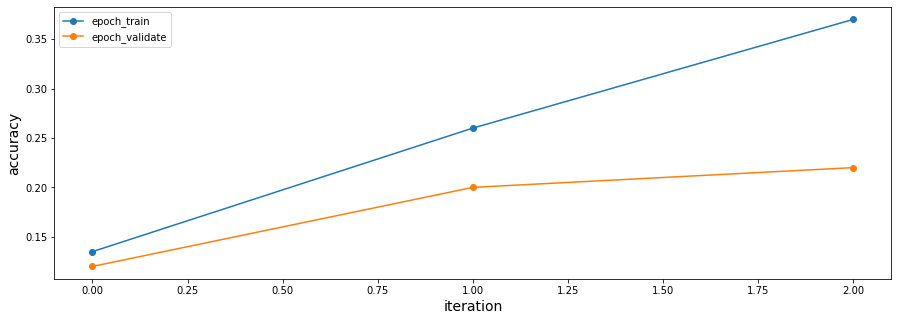

In [70]:
acc_history_mh = train_model(model_mh, criterion_mh, optimizer_mh, schedlr_mh,
                                     loaders, sizes, device, 3)
plot_accs({key: acc_history_mh[key] for key in ['epoch_train', 'epoch_validate']})

## 2-layer fully connected net

In [71]:
hidden_layer_size = 4000

model_fc = nn.Sequential(
    Flatten(),
    nn.Linear(IMAGE_DIM*IMAGE_DIM*3, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, len(class_names))
    ).to(device)
optimizer_fc = optim.SGD(model_fc.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr_fc = lr_scheduler.StepLR(optimizer_fc, step_size=2, gamma=0.1) # lr decay
criterion_fc = nn.CrossEntropyLoss()

validate epoch: [3/3] Loss: 2.4377 ACC@1: 22.00%: 100%|██████████| 3/3 [00:18<00:00,  6.05s/it]


Returning best model, with validation accuracy 0.28


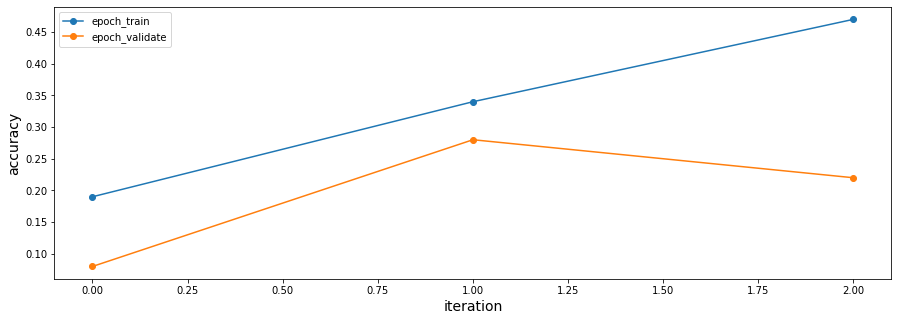

In [72]:
acc_history_fc = train_model(model_fc, criterion_fc, optimizer_fc, schedlr_fc,
                                     loaders, sizes, device, 3)
plot_accs({key: acc_history_fc[key] for key in ['epoch_train', 'epoch_validate']})

## 3-layer ConvNet

In [73]:
channel_1 = 32
channel_2 = 16

# padding chosen to preserve original H/W dimensions
model_cn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=channel_1, kernel_size=5, padding=(5 - 1)//2),
    nn.ReLU(),
    nn.Conv2d(in_channels=channel_1, out_channels=channel_2, kernel_size=3, padding=(3 - 1)//2),
    nn.ReLU(), 
    Flatten(),
    nn.Linear(channel_2*IMAGE_DIM*IMAGE_DIM, len(class_names))
    ).to(device)
optimizer_cn = optim.SGD(model_cn.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr_cn = lr_scheduler.StepLR(optimizer_cn, step_size=2, gamma=0.1) # lr decay
criterion_cn = nn.CrossEntropyLoss()

validate epoch: [3/3] Loss: 1.9298 ACC@1: 14.00%: 100%|██████████| 3/3 [00:18<00:00,  6.23s/it]


Returning best model, with validation accuracy 0.14


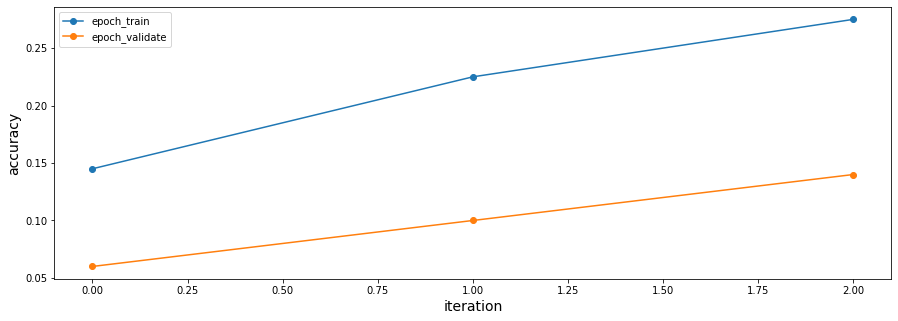

In [74]:
acc_history_cn = train_model(model_cn, criterion_cn, optimizer_cn, schedlr_cn,
                                     loaders, sizes, device, 3)
plot_accs({key: acc_history_cn[key] for key in ['epoch_train', 'epoch_validate']})